# OpenCV 사용해 SSD기반 Object Detection

- OpenCV는 CPU만 사용 가능(GPU 사용불가)

In [1]:
!git clone https://github.com/chulminkw/DLCV.git

Cloning into 'DLCV'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (71/71), done.
Receiving objects: 100% (234/234), 142.72 MiB | 38.24 MiB/s, done.
remote: Total 234 (delta 32), reused 0 (delta 0), pack-reused 159
Resolving deltas: 100% (89/89), done.


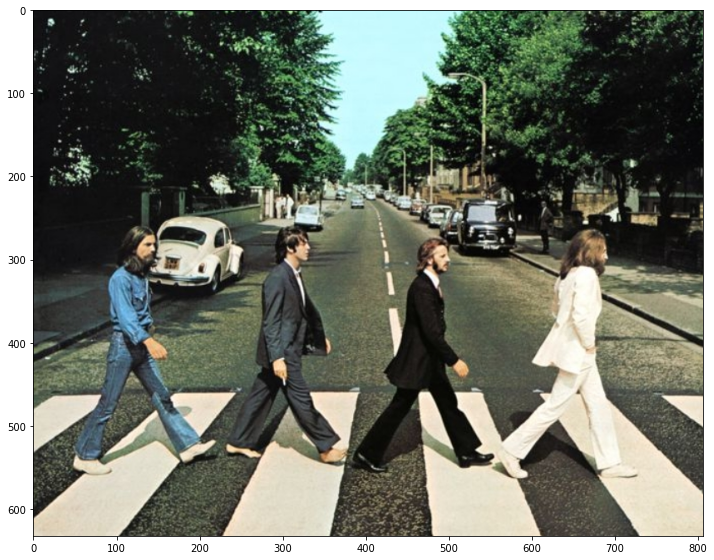

In [2]:
# Object Detection할 이미지 로드
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

default_dir = '/content/DLCV'

img = cv2.imread(os.path.join(default_dir, 'data/image/beatles01.jpg'))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

In [4]:
!ls -lia /content/DLCV/Detection/ssd

total 1740
2097775 drwxr-xr-x 2 root root    4096 Apr 13 07:19 .
2097761 drwxr-xr-x 8 root root    4096 Apr 13 07:19 ..
2097776 -rw-r--r-- 1 root root 1738661 Apr 13 07:19 OpenCV_SSD_이미지와_영상_Detection.ipynb
2097777 -rw-r--r-- 1 root root   10244 Apr 13 07:19 SSD_Face_Detection.ipynb
2097778 -rw-r--r-- 1 root root   17899 Apr 13 07:19 Tensorflow_SSD_이미지와_영상_Detection.ipynb


In [5]:
!mkdir /content/DLCV/Detection/ssd/pretrained
!ls

/content/DLCV/Detection
fast_rcnn  preliminary	retina	ssd  tensor_api  yolo


In [7]:
%cd /content/DLCV/Detection/ssd
!ls

/content/DLCV/Detection/ssd
OpenCV_SSD_이미지와_영상_Detection.ipynb
pretrained
SSD_Face_Detection.ipynb
Tensorflow_SSD_이미지와_영상_Detection.ipynb


In [8]:
# Github에서 Pretrained SSD 모델과 Config 파일 다운로드
%cd /content/DLCV/Detection/ssd/pretrained
!echo "##### downloading pretrained weight file and config pbtxt file"
!wget http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz
!wget https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt

# tar 파일 압축 해제
!echo "##### uncompressing tar file"
!tar -xvf ssd_inception*.gz

# config용 pbtxt 파일의 이름을 graph.pbtxt로 변경
# echo "renaming pbtxt file name"
!mv /content/DLCV/Detection/ssd/pretrained/ssd_inception*.pbtxt /content/DLCV/Detection/ssd/pretrained/ssd_inception_v2_coco_2017_11_17/graph.pbtxt

# tar 파일 삭제
!echo "##### deleting tar file" 
!rm *.gz

# weight파일과 config 파일이 있는 pretrained/faster_rcnn_resnet50_coco_2018_01_28 디렉토리 내부 확인 
!echo "##### check out pretrained/ssd_inception_v2_coco_2017_11_17"
!ls /content/DLCV/Detection/ssd/pretrained/ssd_inception_v2_coco_2017_11_17

/content/DLCV/Detection/ssd/pretrained
##### downloading pretrained weight file and config pbtxt file
--2021-04-13 07:23:31--  http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.15.80, 2607:f8b0:4004:810::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.15.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278126337 (265M) [application/x-tar]
Saving to: ‘ssd_inception_v2_coco_2017_11_17.tar.gz’

ssd_inception_v2_co 100%[===================>] 265.24M   209MB/s    in 1.3s    

2021-04-13 07:23:32 (209 MB/s) - ‘ssd_inception_v2_coco_2017_11_17.tar.gz’ saved [278126337/278126337]

--2021-04-13 07:23:32--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.1

In [9]:
default_ssd_dir = '/content/DLCV/Detection/ssd'
# OpenCV로 텐서플로우 Pretrained 모델 로드하기
cv_net = cv2.dnn.readNetFromTensorflow(os.path.join(default_ssd_dir, 'pretrained/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb'),
                                       os.path.join(default_ssd_dir, 'pretrained/ssd_inception_v2_coco_2017_11_17/graph.pbtxt'))

In [10]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [11]:
# 로드한 비틀즈 이미지 SSD 기반 Object Detection 수행
height = img.shape[0]
width = img.shape[1]

draw_img = img.copy()

# Pretrained 모델에 입력 이미지 넣기
cv_net.setInput(cv2.dnn.blobFromImage(img, size=(300 ,300),
                                      swapRB=True, crop=False))
# Object Detection 수행
cv_out = cv_net.forward()
print(cv_out.shape) # 1개의 이미지에 대해 100개의 바운딩 박스, 7개의 오브젝트 클래스 탐지

(1, 1, 100, 7)


person - score:0.970 class_id: 1
person - score:0.966 class_id: 1
person - score:0.892 class_id: 1
person - score:0.630 class_id: 1
car - score:0.861 class_id: 3
car - score:0.722 class_id: 3
car - score:0.718 class_id: 3
car - score:0.709 class_id: 3
car - score:0.595 class_id: 3
car - score:0.551 class_id: 3


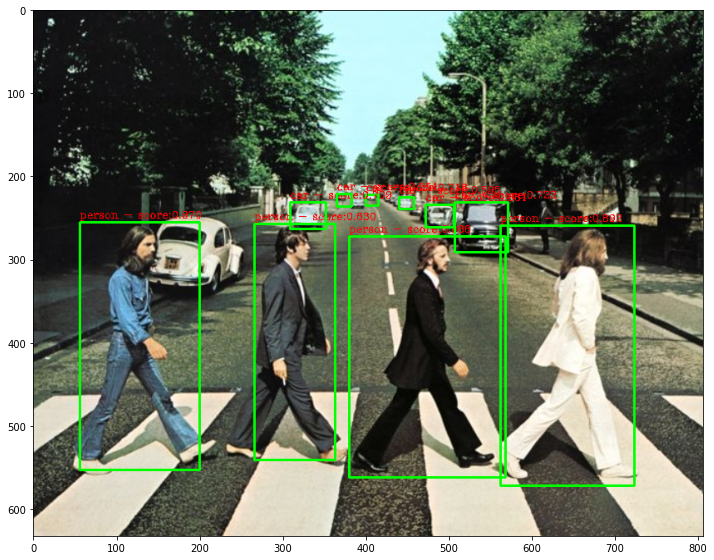

In [14]:
green_color = (0, 255, 0)
red_color = (0, 0, 255)

for detection in cv_out[0, 0, :, :]: # 100개의 바운딩 박스 loop!
  #print(detection.shape)
  #print(detection)  # 0번째 인덱스의 값은 아무의미 없는 것인듯..
  #break
  class_id = int(detection[1])
  score = float(detection[2])
  if score > 0.4:
    # x1, y1, x2, y2 좌표 계산
    left = int(detection[3] * width)
    top = int(detection[4] * height)
    right = int(detection[5] * width)
    bottom = int(detection[6] * height)
    # 바운딩 박스에 새겨넣을 캡션
    caption = f"{labels_to_names[class_id]} - score:{score :.3f}"
    # 이미지에 바운딩 박스 새겨넣기
    cv2.rectangle(draw_img, (left, top), (right, bottom),
                  green_color, thickness=2)
    cv2.putText(draw_img, caption, (left, top-5), cv2.FONT_HERSHEY_COMPLEX,
                0.4, red_color, 1)
    print(caption, 'class_id:', class_id)

# Object Detection 수행한 이미지 RGB로 변환
img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

In [22]:
# 단일 이미지에 대한 Object Detection 함수화
import time

def get_detected_img(cv_net, img_array, score_threshold,
                     use_copied_array=True, is_print=True):
  height = img_array.shape[0]
  width = img_array.shape[1]

  draw_img = None # ?왜있는거지?
  if use_copied_array:
    draw_img = img_array.copy()
  else:
    draw_img = img_array
  
  # 로드한 Pretrained 모델에 입력 이미지 넣기
  cv_net.setInput(cv2.dnn.blobFromImage(img_array, size=(300, 300),
                                        swapRB=True, crop=False))
  start = time.time()  # 수행시간 측정
  # Pretrained 모델로 Object Detection 수행
  cv_out = cv_net.forward()

  green_color = (0, 255, 0)
  blue_color = (0, 0, 255)

  for detection in cv_out[0, 0, :, :]:
    class_id = int(detection[1])
    score = float(detection[2])
    if score > score_threshold:
      # 좌표 계산
      left = int(detection[3] * width)
      top = int(detection[4] * height)
      right = int(detection[5] * width)
      bottom = int(detection[6] * height)

      caption = f"{labels_to_names[class_id]} - {score :.3f}"
      # 바운딩 박스와 캡션 넣기
      cv2.rectangle(draw_img, (left, top), (right, bottom),
                    green_color, thickness=2)
      cv2.putText(draw_img, caption, (left, top-5), cv2.FONT_HERSHEY_SIMPLEX,
                  0.5, blue_color, 1)
  if is_print:
    print('Detection 수행시간:', time.time() - start, '초')
  # RGB로 변환
  return draw_img

Detection 수행시간: 0.3639695644378662 초


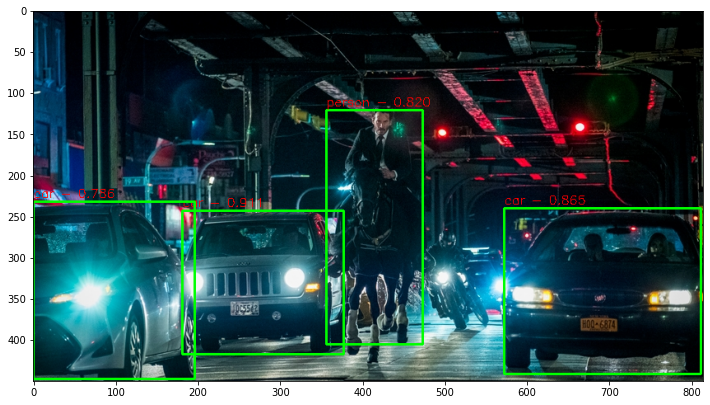

In [23]:
img = cv2.imread(os.path.join(default_dir, 'data/image/john_wick01.jpg'))
cv_net = cv2.dnn.readNetFromTensorflow(os.path.join(default_ssd_dir, 'pretrained/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb'),
                                       os.path.join(default_ssd_dir, 'pretrained/ssd_inception_v2_coco_2017_11_17/graph.pbtxt'))

draw_img = get_detected_img(cv_net, img, 0.4, True, True)
# RGB로 변환
img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12 ,12))
plt.imshow(img_rgb)


# Video Object Detection 수행

In [24]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('/content/DLCV/data/video/John_Wick_small.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
  <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [27]:
# Video Object Detection 수행하는 함수 만들기

def do_detected_video(cv_net, input_path, output_path,
                      score_threshold, is_print):
  # VideoCapture에 인풋경로 정의
  cap = cv2.VideoCapture(input_path)
  # 코덱, 비디오 프레임 사이즈, FPS 값 Frame 개수 얻기
  codec = cv2.VideoWriter_fourcc(*"XVID")
  vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
              round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
  vid_fps = cap.get(cv2.CAP_PROP_FPS)
  frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  # VideoWriter에 아웃풋 경로, 코덱, FPS값, 프레임 사이즈 정의
  vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)
  print("총 프레임 개수:", vid_fps)

  green_color = (0, 255, 0)
  red_color = (0, 0, 255)
  # 한 프레임마다 Object Detection 수행
  while True:
    hasFrame, imgFrame = cap.read()
    if not hasFrame:
      print("더 상 처리할 프레임이 없습니다!")
      break
    
    after_frame = get_detected_img(cv_net,imgFrame, score_threshold,
                                   is_print)
    # 디텍션 수행한 프레임을 write하기
    vid_writer.write(after_frame)
  
  vid_writer.release()
  cap.release()

In [28]:
default_dir = '/content/DLCV'
do_detected_video(cv_net,
                  os.path.join(default_dir, 'data/video/John_Wick_small.mp4'),
                  os.path.join(default_dir,'data/output/John_Wick_small_ssd01.avi'),
                  0.4, True)

총 프레임 개수: 30.00051725029742
Detection 수행시간: 0.35405826568603516 초
Detection 수행시간: 0.3615283966064453 초
Detection 수행시간: 0.3836207389831543 초
Detection 수행시간: 0.3548874855041504 초
Detection 수행시간: 0.3707292079925537 초
Detection 수행시간: 0.3747117519378662 초
Detection 수행시간: 0.3592522144317627 초
Detection 수행시간: 0.36450886726379395 초
Detection 수행시간: 0.3569626808166504 초
Detection 수행시간: 0.35852622985839844 초
Detection 수행시간: 0.3675415515899658 초
Detection 수행시간: 0.3561556339263916 초
Detection 수행시간: 0.354215145111084 초
Detection 수행시간: 0.3580136299133301 초
Detection 수행시간: 0.3566129207611084 초
Detection 수행시간: 0.3752446174621582 초
Detection 수행시간: 0.35573816299438477 초
Detection 수행시간: 0.3668391704559326 초
Detection 수행시간: 0.36100149154663086 초
Detection 수행시간: 0.3555169105529785 초
Detection 수행시간: 0.3674929141998291 초
Detection 수행시간: 0.3651418685913086 초
Detection 수행시간: 0.3560802936553955 초
Detection 수행시간: 0.3565359115600586 초
Detection 수행시간: 0.3592081069946289 초
Detection 수행시간: 0.36565542221069336 초
Detec

# Mobile Net기반 SSD 모델 사용

In [29]:
### 코랩 버전은 아래를 이용하여 os command 를 수행합니다. 

# coco 데이터 세트로 pretrained 된 ssd 파일과 config용 graph pbtxt 다운로드 
%cd /content/DLCV/Detection/ssd/pretrained
!echo "##### downloading pretrained weight file and config pbtxt file"
!wget  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
!wget https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_mobilenet_v2_coco_2018_03_29.pbtxt


# tar 파일 압축 해제
!echo "##### uncompressing tar file"
!tar -xvf ssd_mobilenet_v2_coco_2018_03_29.tar.gz

# config용 pbtxt 파일의 이름을 graph.pbtxt로 변경
# echo "renaming pbtxt file name"
!mv /content/DLCV/Detection/ssd/pretrained/ssd_mobilenet_v2_coco_2018_03_29.pbtxt /content/DLCV/Detection/ssd/pretrained/ssd_mobilenet_v2_coco_2018_03_29/graph.pbtxt

# tar 파일 삭제
!echo "##### deleting tar file" 
!rm *.gz

# weight파일과 config 파일이 있는 pretrained/faster_rcnn_resnet50_coco_2018_01_28 디렉토리 내부 확인 
!echo "##### check out pretrained/ssd_mobilenet_v2_coco_2018_03_29"
!ls /content/DLCV/Detection/ssd/pretrained/ssd_mobilenet_v2_coco_2018_03_29

/content/DLCV/Detection/ssd/pretrained
##### downloading pretrained weight file and config pbtxt file
--2021-04-13 08:00:41--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.73.240, 2607:f8b0:4004:810::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.73.240|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187925923 (179M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_coco_2018_03_29.tar.gz’

ssd_mobilenet_v2_co 100%[===================>] 179.22M   284MB/s    in 0.6s    

2021-04-13 08:00:41 (284 MB/s) - ‘ssd_mobilenet_v2_coco_2018_03_29.tar.gz’ saved [187925923/187925923]

--2021-04-13 08:00:42--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_mobilenet_v2_coco_2018_03_29.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199

Detection 수행시간: 0.24411964416503906 초


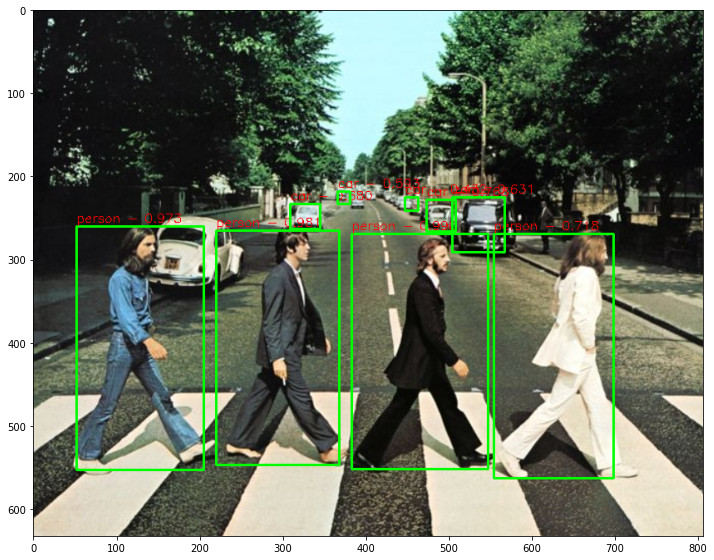

In [31]:
default_dir = '/content/DLCV'
default_ssd_dir = '/content/DLCV/Detection/ssd'
img = cv2.imread(os.path.join(default_dir, 'data/image/beatles01.jpg'))

# Pretrained 모델 로드
cv_net_mobile = cv2.dnn.readNetFromTensorflow(os.path.join(default_ssd_dir, 'pretrained/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb'), 
                                              os.path.join(default_ssd_dir, 'pretrained/ssd_mobilenet_v2_coco_2018_03_29/graph.pbtxt'))

draw_img = get_detected_img(cv_net_mobile, img, 0.4,
                            True, True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)